In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but StandardScaler was fitted with feature names")

In [2]:
%cd ..
%cd data
full_data = pd.read_csv('yields_cleaned.csv')
cluster_fts = full_data[['Credit Rating', '6 Month Performance']]
cluster_fts.head()

/Users/jamiewong/Documents/esg-financial-assistant
/Users/jamiewong/Documents/esg-financial-assistant/data


,Credit Rating,6 Month Performance
0,0,-0.0216
1,13,0.1036
2,0,0.0477
3,0,0.2223
4,12,0.0764


In [3]:
scaler = StandardScaler()
scaled_fts = scaler.fit_transform(cluster_fts)

In [9]:
inertias = []
silhouette_scores = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(scaled_fts)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_fts, labels))

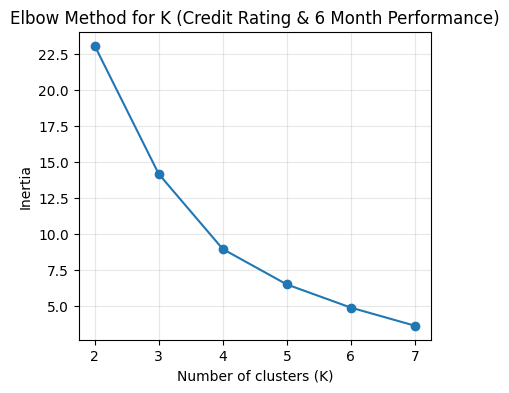

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(k_range), inertias, marker='o')
plt.title('Elbow Method for K (Credit Rating & 6 Month Performance)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)

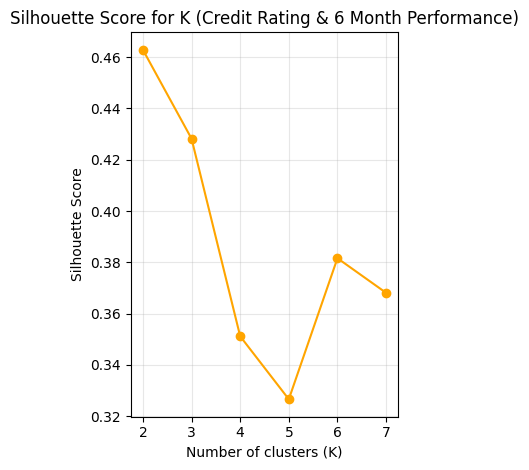

In [11]:
plt.subplot(1,2,2)
plt.plot(list(k_range), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for K (Credit Rating & 6 Month Performance)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
k = 3
kmeans_5 = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels_5 = kmeans_5.fit_predict(scaled_fts)
full_data[f'risk_return_cluster_{k}'] = labels_5

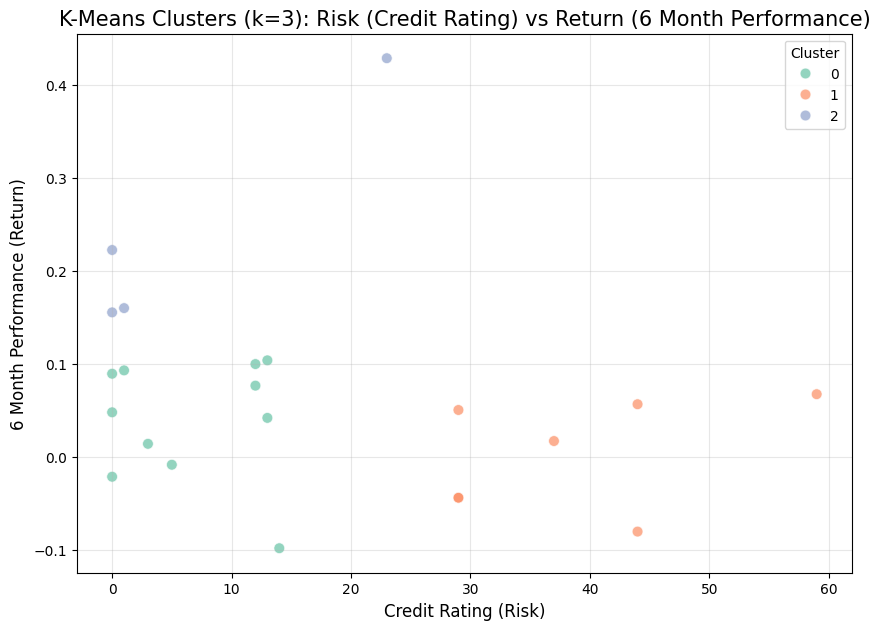

In [19]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=full_data['Credit Rating'],
    y=full_data['6 Month Performance'],
    hue=full_data[f'risk_return_cluster_{k}'],
    palette='Set2',
    alpha=0.7,
    s=60
)
plt.title(f'K-Means Clusters (k={k}): Risk (Credit Rating) vs Return (6 Month Performance)', fontsize=15)
plt.xlabel('Credit Rating (Risk)', fontsize=12)
plt.ylabel('6 Month Performance (Return)', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
def recommendation(user_risk, user_performance, e_weight, s_weight, g_weight):
    """
    Assign user to a cluster and recommend stocks sorted by ESG fields in order of user weight (descending).
    If two or more weights are equal and the highest, only the first highest field is used for sorting.
    If all three weights are equal, sort by 'environment_score' only.
    """
    
    weight_dict = {
        'environment_score': e_weight,
        'social_score': s_weight,
        'governance_score': g_weight
    }
    # Sort 
    sorted_fields = sorted(weight_dict, key=weight_dict.get, reverse=True)
    # Check for ties 
    max_weight = max(weight_dict.values())
    max_fields = [field for field, w in weight_dict.items() if w == max_weight]
    if len(max_fields) > 1:
        if len(max_fields) == 3:
            print("All ESG weights are equal. Sorting by 'environment_score' only.")
            sorted_fields = ['environment_score']
        else:
            print(f"Multiple highest weights detected. Sorting by '{max_fields[0]}' only.")
            sorted_fields = [max_fields[0]]
    else:
        print(f"Automatic sorting order: {sorted_fields}")
    # tandardize 
    user_features = scaler.transform([[user_risk, user_performance]])
    # Predict
    user_cluster = kmeans.predict(user_features)[0]
    print(f"User assigned to cluster {user_cluster}")
    user_cluster_stocks = full_data[full_data[f'risk_return_cluster_{k}'] == user_cluster].copy()
    # Sort 
    user_cluster_stocks = user_cluster_stocks.rename(columns={
        'E Score': 'environment_score', 
        'S Score': 'social_score', 
        'G Score': 'governance_score'})
    user_cluster_stocks = user_cluster_stocks.sort_values(by=sorted_fields, ascending=[False]*len(sorted_fields))
    # Recommend
    top_recommend = user_cluster_stocks.head(3)
    print("Top 3 recommended bonds:")
    print(top_recommend[['Country Name', 'Credit Rating', '6 Month Performance', 'environment_score', 'social_score', 'governance_score']])
    # save
    top_recommend.to_csv('user_recommended_stocks.csv', index=False)
    #print("Top 10 recommended stocks have been saved to 'user_recommended_stocks.csv'.")
    return top_recommend

In [30]:
recommendation(10, 0.2, 0.3, 0.5, 0.2)

Automatic sorting order: ['social_score', 'environment_score', 'governance_score']
User assigned to cluster 2
Top 3 recommended bonds:
   Country Name  Credit Rating  6 Month Performance  environment_score  \
19       Sweden              1               0.1598           0.851642   
3       Denmark              0               0.2223           0.750027   
5       Germany              0               0.1552           0.767347   

    social_score  governance_score  
19      0.845986          0.772606  
3       0.803905          0.846567  
5       0.772925          0.736296  


,Unnamed: 0,Country Name,Credit Rating,environment_score,social_score,governance_score,ESG Score,6 Month Performance,risk_return_cluster_3
19,19,Sweden,1,0.851642,0.845986,0.772606,2.470234,0.1598,2
3,3,Denmark,0,0.750027,0.803905,0.846567,2.400499,0.2223,2
5,5,Germany,0,0.767347,0.772925,0.736296,2.276569,0.1552,2
